# ICE Membership Inference Experiments

In [1]:
import pandas as pd
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import numpy as np
import random
import logging
import sys
import time
import multiprocessing

threads = 4

This notebook will go through the experiment for membership inference with individual conditional expectation (ICE). Membership inference means an attacker with access to the explanation can tell with high confidence for any sample whether it was included in the training data or not.

The idea for ICE membership inference is as follows: The attacker can recreate the ICE lines for any sample and check whether they occur in the given explanation. If they do, there is a high chance that the sample was used in the training data (which was also used to create the ICE explanation). Otherwise the sample was not included in the training data.

First, we define two functions that will help us run the experiment later.

The first function can execute membership inference for ICE explanations. It takes an array of samples, a list of ICE explanations (for different features) and the prediction function of the machine learning model and returns true or false for each sample. True if it guesses the sample is part of the training data, false otherwise.

In [109]:
# samples: numpy array with feature values of samples
# ice_features: list of ice explanations (one for each feature)
# pred_func: prediction function by model. Takes an array of samples and returns array of predictions.
# class_num: index for output of pred_func: class to consider for ice explanation
# returns: true if sample appears to be part of training data, false otherwise
def membership_inference_ice_parallel(samples, ice_features, pred_func, class_num):
    
    # Recreate ice lines for all given features for the samples.
    
    results = np.empty(samples.shape[0])

    for i in range(samples.shape[0]):
    
        sample = samples[i]
    
        for num, ice in enumerate(ice_features):

            # Get the grid for this feature. These are the points at which we will get predictions from the model.
            feature_values = ice['values'][0]

            # Create array that contains the sample as many times as there are different grid points for this feature.
            changed_samples = np.tile(sample, (feature_values.shape[0], 1))

            # Change each copied samples feature in question to a point from the grid.
            changed_samples[:, num] = feature_values

            # Get the predictions for these changed samples.
            preds = pred_func(changed_samples)[:, class_num]

            # First, create array with boolean values whether the recreated predictions and the actual ICE predictions match.
            # Then check if there is any row where all elements are true. 
            # That means there is at least one ICE line with identical predictions.
            res = (preds == ice['individual'][0]).all(1).any()

            # If there is no identical ICE line for this feature, the sample can't be part of the training data.
            # Break out of loop. res is false and will be appended to the list of results.
            if res == False:
                break;

        logging.debug("%s membership inference: %s" % (sample, res))
                
        # This appends the last res to the results list. If a matching line for every feature was found, this is true 
        # (sample is in training data). Otherwise the last res will be false (sample is not in training data)
        results[i] = res
        
    return results

Next, we will define a function that executes the entire experiment. It takes the features and the labels as panda dataframes and the number of features for which ice should be calculated. The data is split in two halves. One is used as training data, the other as control data for the experiment. After training a random forest on the training data, ICE graphs are created for the specified features. Samples are randomly drawn from either the training data or the control data. Then the membership_inference function is called on the sample and its result is catalogued based on whether the membership was inferred correctly or not. Finally, the result of the experiment is printed out with the overall accuracy of membership inference and the sensitivity and specificity.

In [149]:
# features: pandas dataframe of the features of the data
# labels: pandas dataframe of the labels of the data corresponding to the features
# num_of_ice_features: number of ICE graphs that are supplied to the attacker
# repetitions: number of times the experiment is repeated
# random_state: seed for random decisions
# clf: machine learning classifier that will be trained on the features and labels
def experiment(features, labels, num_of_ice_features, repetitions=30, random_state=17,\
               clf=es.RandomForestClassifier(random_state=17)):
    
    rs = np.random.RandomState(seed=random_state)
    
    # Split data into two halves.
    idx_mid = int(features.shape[0] / 2)

    x_ctrl = features.iloc[:idx_mid, :]
    y_ctrl = labels.iloc[:idx_mid]

    x_train = features.iloc[idx_mid:, :]
    y_train = labels.iloc[idx_mid:]
    
    # Train classifier on training data.
    clf = clf.fit(x_train, y_train)
    
    # Calculate ICE for the specified feature indexes
    ice_features = []
    
    for i in range(num_of_ice_features):
        ice_features.append(partial_dependence(estimator=clf, X=x_train, features=[i], percentiles=(0,1), 
                                         grid_resolution=20, kind='individual'))
    
    sample_membership = np.empty(repetitions)
    
    samples = np.empty((repetitions, features.shape[1]))
    
    for i in range(repetitions):
        if i % 2 == 0:
            # Choose sample from training data.
            sample = x_train.sample(random_state=rs).to_numpy()[0]
            sample_membership[i] = True
            logging.debug('%s taken from training data' % sample)
        else:
            # Choose sample from control data.
            sample = x_ctrl.sample(random_state=rs).to_numpy()[0]
            sample_membership[i] = False
            logging.debug('%s taken from control data' % sample)

        samples[i] = sample
        
    samples_in_training_data = np.count_nonzero(sample_membership)
    samples_not_in_training_data = repetitions - samples_in_training_data
        
    arg_list = []
    
    samples_per_thread = repetitions / threads
    
    for i in range(threads):
        start_idx = int(i * samples_per_thread)
        end_idx = int((i + 1) * samples_per_thread)
        arg_list.append((samples[ start_idx : end_idx ], ice_features, clf.predict_proba, 1))
    
    logging.debug("Begin membership inference for selected samples:")
    
    with multiprocessing.Pool(threads) as p:
        results = p.starmap(membership_inference_ice_parallel, arg_list)
        
    results_np = np.concatenate(results)
    
    correct_predictions = np.count_nonzero(np.equal(results_np, sample_membership))
    predict_in_training_data_correct = np.count_nonzero(results_np[sample_membership == True])
    predict_not_in_training_data_correct = np.count_nonzero(results_np[sample_membership == False] == False)
                
    ratio_correct = correct_predictions / repetitions
    ratio_correct_td = predict_in_training_data_correct / samples_in_training_data
    ratio_correct_cd = predict_not_in_training_data_correct / samples_not_in_training_data
        
    print('Membership Inference Accuracy: %s, Sensitivity: %s, Specificity: %s'\
          % (ratio_correct, ratio_correct_td, ratio_correct_cd))
    
    return ratio_correct, ratio_correct_td, ratio_correct_cd

# Dataset 1: Heart Disease (continuous)

Load dataset one: heart disease

In [2]:
filename = '../data/framingham.csv'

names = ['sex', 'age', 'education', 'smoker', 'cigs_per_day', 'bp_meds', 'prevalent_stroke', 'prevelant_hyp', 'diabetes', \
         'total_chol', 'sys_bp', 'dia_bp', 'bmi', 'heart_rate', 'glucose', 'heart_disease_label']

data = pd.read_csv(filename, names=names)

For this dataset we only look at numerical data so we drop the categorical columns. We also drop the column "education" for which there is no feature description on kaggle: https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression

In [4]:
data_num = data.drop('sex', axis=1).drop('smoker', axis=1).drop('bp_meds', axis=1).drop('prevalent_stroke', axis=1)\
    .drop('prevelant_hyp', axis=1).drop('diabetes', axis=1).drop('education', axis=1)

data_num.head(5)

,age,cigs_per_day,total_chol,sys_bp,dia_bp,bmi,heart_rate,glucose,heart_disease_label
0,39,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,46,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,48,20.0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,61,30.0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,46,23.0,285.0,130.0,84.0,23.10,85.0,85.0,0


Remove any rows that are missing data. Afterwards there should be no more entries with NaN values. We also drop any duplicate rows.

In [113]:
data_num = data_num.dropna()
data_num = data_num.drop_duplicates()

data_num.isnull().sum()

age                    0
cigs_per_day           0
total_chol             0
sys_bp                 0
dia_bp                 0
bmi                    0
heart_rate             0
glucose                0
heart_disease_label    0
dtype: int64

For the experiments, we split the data into features and labels. We also create features and labels for only the first 100 training samples.

In [114]:
features = data_num.drop('heart_disease_label', axis=1)
labels = data_num['heart_disease_label']

# We need to select 200 samples because only half the data will be used as training data. 
# 200 total samples results in 100 training samples
data_num_200 = data_num.sample(n = 200, random_state=13)
features_200 = data_num_200.drop('heart_disease_label', axis=1)
labels_200 = data_num_200['heart_disease_label']

Before running the experiment, we we will have a short look at the visual explanation of ICE. The underlying data of these graphs will be our attack vector for membership inference.

The dark blue lines represent the average change in predictions for a change in the specified feature. The light blue lines are the change in prediction for single samples from the training data. These are the ICE lines for individual samples from the training data.

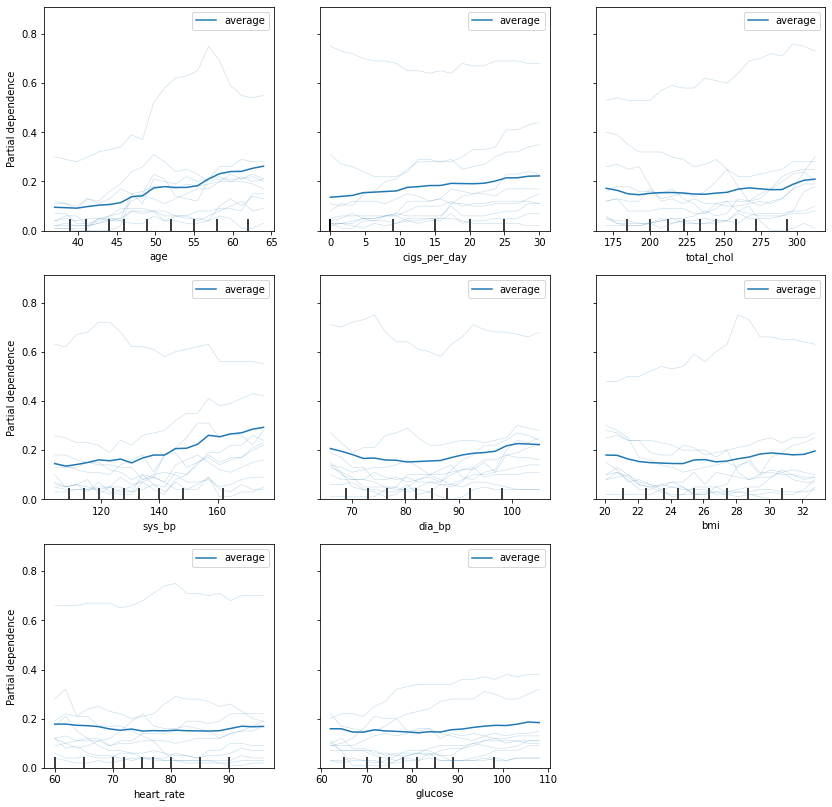

In [96]:
# Train a random forest classifier on training data.
clf = es.RandomForestClassifier(random_state=0)
clf = clf.fit(features, labels)

feature_names = ['age', 'cigs_per_day', 'total_chol', 'sys_bp', 'dia_bp', 'bmi', 'heart_rate', 'glucose']

fig, ax = plt.subplots(figsize=(14, 14))

display = plot_partial_dependence(
       clf, features, feature_names, kind="both", subsample=10,
       n_jobs=3, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

As a proof of concept for our privacy attack, we run the experiment with a very small amount of repetitions with logging to show that the membership inference function works in principle.

In [145]:
logging.root.setLevel(logging.DEBUG)

experiment(features, labels, 1, repetitions=8, random_state=42)

logging.root.setLevel(logging.INFO)

DEBUG:root:[ 54.     3.   173.   121.    79.    26.21  75.    68.  ] taken from training data
DEBUG:root:[ 60.    20.   285.   131.5   82.    27.87  60.   103.  ] taken from control data
DEBUG:root:[ 63.     0.   306.   195.   105.    27.96  75.    87.  ] taken from training data
DEBUG:root:[ 54.    30.   215.   117.5   70.5   26.77  60.    75.  ] taken from control data
DEBUG:root:[ 48.     0.   237.   124.5   66.5   33.29  80.    91.  ] taken from training data
DEBUG:root:[ 60.    0.  278.  160.5  96.   26.4  55.   75. ] taken from control data
DEBUG:root:[ 40.    30.   162.   129.    76.5   24.12  70.    73.  ] taken from training data
DEBUG:root:[ 44.     0.   190.   122.    81.    36.12  70.   143.  ] taken from control data
DEBUG:root:Begin membership inference for selected samples:
DEBUG:root:[ 54.     3.   173.   121.    79.    26.21  75.    68.  ] membership inference: True
DEBUG:root:[ 60.    20.   285.   131.5   82.    27.87  60.   103.  ] membership inference: False
DEBUG:r

Membership Inference Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0


The proof of concept should show that the membership inference function predicts membership very accurately. You can change the random state to try out a few different runs with different tested samples.

Now we begin executing the actual experiment. We begin by defining the matrix that will hold the results for all our different experiment variations. Then we execute the first variation of the experiment for this dataset.

In [150]:
results_ = {'dataset': [], 'ice_features': [], 'training_samples': [], 'model': [], \
            'accuracy': [], 'sensitivity': [], 'specificity': []}

results = pd.DataFrame(data = results_)

In [151]:
print("features: continuous, ICE plots: one, training samples: all, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features, labels, 1, repetitions=100, random_state=0,\
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', '1', 'all', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: one, training samples: all, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 0.22829580307006836 seconds ---


In the following cells, we vary the number of shown ICE explanations, the number of training samples and the model.

In [152]:
print("features: continuous, ICE plots: one, training samples: all, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features, labels, 1, repetitions=100, random_state=0,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', '1', 'all', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: one, training samples: all, model: random forest.
Membership Inference Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0
--- 1.3817002773284912 seconds ---


In [153]:
print("features: continuous, ICE plots: one, training samples: 100, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_200, labels_200, 1, repetitions=100, random_state=0, \
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', '1', '100', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: one, training samples: 100, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 0.19377803802490234 seconds ---


In [154]:
print("features: continuous, ICE plots: one, training samples: 100, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_200, labels_200, 1, repetitions=100, random_state=0,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', '1', '100', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: one, training samples: 100, model: random forest.
Membership Inference Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0
--- 0.7735249996185303 seconds ---


In [155]:
print("features: continuous, ICE plots: all, training samples: all, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features, labels, 8, repetitions=100, random_state=0, \
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', 'all', 'all', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: all, training samples: all, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 0.5764865875244141 seconds ---


In [156]:
print("features: continuous, ICE plots: all, training samples: all, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features, labels, 8, repetitions=100, random_state=1,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', 'all', 'all', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: all, training samples: all, model: random forest.
Membership Inference Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0
--- 6.690122365951538 seconds ---


In [157]:
print("features: continuous, ICE plots: all, training samples: 100, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_200, labels_200, 8, repetitions=100, random_state=1,\
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', 'all', '100', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: all, training samples: 100, model: decision tree.
Membership Inference Accuracy: 0.53, Sensitivity: 1.0, Specificity: 0.06
--- 0.44295263290405273 seconds ---


In [158]:
print("features: continuous, ICE plots: all, training samples: 100, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_200, labels_200, 8, repetitions=100, random_state=1,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['continuous', 'all', '100', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: continuous, ICE plots: all, training samples: 100, model: random forest.
Membership Inference Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0
--- 3.508394241333008 seconds ---


# Dataset 2: Census Income (categorical)

Load dataset two: census income

In [5]:
filename = '../data/adult.data.csv'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', \
         'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label']

data_cat = pd.read_csv(filename, names=names)

In [6]:
data_cat.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There is missing data in the columns workclass and native_country that needs to be removed.

In [7]:
print("Unique values of columns before removal: ")
print(data_cat.workclass.unique())
print(data_cat.native_country.unique())

data_cat = data_cat[data_cat.workclass != ' ?']
data_cat = data_cat[data_cat.native_country != ' ?']

print("Unique values of columns after removal: ")
print(data_cat.workclass.unique())
print(data_cat.native_country.unique())

Unique values of columns before removal: 
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']
Unique values of columns after removal: 
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' United-States' ' Cuba' ' Jamaica' ' India' ' Mexico' ' Puerto-Rico'
 ' Honduras' ' England' ' Canada' ' Germany' ' Iran' ' Philippines'
 ' Poland' ' Colu

We will only use the categorical features of this dataset. Remove continuous columns:

In [8]:
data_cat = data_cat.drop('age', axis=1).drop('fnlwgt', axis=1).drop('education_num', axis=1).drop('capital_gain', axis=1)\
    .drop('capital_loss', axis=1).drop('hours_per_week', axis=1)

data_cat.head(3)

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,label
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K


Transform workclass, education, marital_status, occupation, relationship, race, sex and native_country into one-hot encoded features:

In [9]:
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['workclass'], prefix='workclass')], axis=1)
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['education'], prefix='education')], axis=1)
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['marital_status'], prefix='marital_status')], axis=1)
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['occupation'], prefix='occupation')], axis=1)
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['relationship'], prefix='relationship')], axis=1)
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['race'], prefix='race')], axis=1)
data_cat = pd.concat([data_cat, pd.get_dummies(data_cat['native_country'], prefix='native_country')], axis=1)

data_cat = data_cat.drop('workclass', axis=1).drop('education', axis=1).drop('marital_status', axis=1)\
    .drop('occupation', axis=1).drop('relationship', axis=1).drop('race', axis=1).drop('native_country', axis=1)

data_cat.head(3)

,sex,label,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,Male,<=50K,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,Male,<=50K,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Male,<=50K,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Transform label and sex into binary encoding:

In [10]:
data_cat['female'] = data_cat['sex'].map( {' Male': 0, ' Female': 1} )
data_cat['>50K'] = data_cat['label'].map( {' <=50K': 0, ' >50K': 1} )

data_cat = data_cat.drop('sex', axis=1).drop('label', axis=1)

data_cat.head(3)

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,...,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia,female,>50K
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [131]:
data_cat = data_cat.drop_duplicates()

features_cat = data_cat.drop('>50K', axis=1)
labels_cat = data_cat['>50K'] 

# We need to select 200 samples because only half the data will be used as training data
# 200 total samples results in 100 training samples
data_cat_200 = data_cat.sample(n = 200, random_state=13)
features_cat_200 = data_cat_200.drop('>50K', axis=1)
labels_cat_200 = data_cat_200['>50K'] 

Now all variations of the membership inference experiment will be executed for the second dataset.

In [159]:
print("features: categorical, ICE plots: one, training samples: all, model: decision tree.")


start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat, labels_cat, 1, repetitions=100, random_state=1,\
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', '1', 'all', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: one, training samples: all, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 0.23042988777160645 seconds ---


In [160]:
print("features: categorical, ICE plots: one, training samples: all, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat, labels_cat, 1, repetitions=100, random_state=1,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', '1', 'all', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: one, training samples: all, model: random forest.
Membership Inference Accuracy: 0.76, Sensitivity: 1.0, Specificity: 0.52
--- 1.3187973499298096 seconds ---


In [161]:
print("features: categorical, ICE plots: one, training samples: 100, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat_200, labels_cat_200, 1, repetitions=100, random_state=1,\
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', '1', '100', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: one, training samples: 100, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 0.17108893394470215 seconds ---


In [162]:
print("features: categorical, ICE plots: one, training samples: 100, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat_200, labels_cat_200, 1, repetitions=100, random_state=1,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', '1', '100', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: one, training samples: 100, model: random forest.
Membership Inference Accuracy: 0.87, Sensitivity: 1.0, Specificity: 0.74
--- 0.5967433452606201 seconds ---


In [163]:
print("features: categorical, ICE plots: all, training samples: all, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat, labels_cat, 99, repetitions=100, random_state=1,\
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', 'all', 'all', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: all, training samples: all, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 1.734576940536499 seconds ---


In [164]:
print("features: categorical, ICE plots: all, training samples: all, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat, labels_cat, 99, repetitions=100, random_state=1,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', 'all', 'all', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: all, training samples: all, model: random forest.
Membership Inference Accuracy: 0.95, Sensitivity: 1.0, Specificity: 0.9
--- 33.55830383300781 seconds ---


In [165]:
print("features: categorical, ICE plots: all, training samples: 100, model: decision tree.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat_200, labels_cat_200, 99, repetitions=100, random_state=1,\
                                                clf=DecisionTreeClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', 'all', '100', 'decision tree', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: all, training samples: 100, model: decision tree.
Membership Inference Accuracy: 0.5, Sensitivity: 1.0, Specificity: 0.0
--- 0.8738939762115479 seconds ---


In [166]:
print("features: categorical, ICE plots: all, training samples: 100, model: random forest.")

start_time = time.time()

accuracy, sensitivity, specificity = experiment(features_cat_200, labels_cat_200, 99, repetitions=100, random_state=1,\
                                                clf=es.RandomForestClassifier(random_state=0))

results.loc[len(results.index)] = ['categorical', 'all', '100', 'random forest', accuracy, sensitivity, specificity]

print("--- %s seconds ---" % (time.time() - start_time))

features: categorical, ICE plots: all, training samples: 100, model: random forest.
Membership Inference Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0
--- 16.10212779045105 seconds ---


# Results

The results of all variations of the membership inference experiment with ICE. In each experiment, half the samples were picked randomly from the training data, while the other half were picked randomly from the control data not used for training. Both datasets originate from the same source dataset.

Accuracy is the percentage of samples whose membership (true or false) was correctly inferred. An algorithm guessing at random would achieve an accuracy of 50 percent.

Sensitivity is the percentage of training samples whose membership (true) was correctly inferred.

Specificity is the percentage of control samples (not used for training) whose membership (false) was correctly inferred.

In [167]:
results

,dataset,ice_features,training_samples,model,accuracy,sensitivity,specificity
0,continuous,1,all,decision tree,0.50,1.0,0.00
1,continuous,1,all,random forest,1.00,1.0,1.00
2,continuous,1,100,decision tree,0.50,1.0,0.00
3,continuous,1,100,random forest,1.00,1.0,1.00
4,continuous,all,all,decision tree,0.50,1.0,0.00
5,continuous,all,all,random forest,1.00,1.0,1.00
6,continuous,all,100,decision tree,0.53,1.0,0.06
7,continuous,all,100,random forest,1.00,1.0,1.00
8,categorical,1,all,decision tree,0.50,1.0,0.00
9,categorical,1,all,random forest,0.76,1.0,0.52
